In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv
/kaggle/input/game-of-deep-learning-ship-datasets/sample_submission_ns2btKE.csv
/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2213022.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2842076.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2862031.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2880224.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2821082.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2833446.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2847421.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2851911.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2794325.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/725088.jpg
/kaggle/input/game-of-deep-learning-sh

In [2]:
import pandas as pd
from sklearn.utils import resample
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
from PIL import Image

# Charger le dataframe
df = pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv', 
                 dtype={'image': 'object', 'category': 'int8'})

# Définir les classes et leur code
class_to_code = {'Cargo': 1, 'Military': 2, 'Carrier': 3, 'Cruise': 4, 'Tankers': 5}

# Suréchantillonnage pour équilibrer les classes
max_class_count = max(df['category'].value_counts())
oversampled_dfs = []


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
max_class_count

2120

In [4]:
for class_label, class_code in class_to_code.items():
    class_df = df[df['category'] == class_code]
    oversampled_class_df = resample(class_df, replace=True, n_samples=max_class_count, random_state=42)
    oversampled_dfs.append(oversampled_class_df)

df_oversampled = pd.concat(oversampled_dfs)


In [5]:
df_oversampled['category'].value_counts()

category
1    2120
2    2120
3    2120
4    2120
5    2120
Name: count, dtype: int64

In [6]:

# Définir les transformations de données
training_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.3, 0.3), scale=(0.5, 1.5), shear=None),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Définir un Dataset personnalisé pour les images
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = int(self.dataframe.iloc[idx, 1]) - 1  # Convertir les étiquettes à partir de 1-index à 0-index

        return image, label

# Créer un DataLoader avec le Dataset équilibré et les transformations
dataset = CustomDataset(dataframe=df_oversampled, root_dir='/kaggle/input/game-of-deep-learning-ship-datasets/train/images', transform=training_transforms)



In [7]:
len(dataset)

10600

In [9]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [10]:
len(dataloader)

166

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import Adam
from sklearn.metrics import classification_report
from tqdm import tqdm

# Assurez-vous d'avoir défini votre DataLoader avec les transformations
# dataset = CustomDataset(dataframe=df_oversampled, root_dir='C:/Users/merie/Downloads/archive (1)/train/images', transform=training_transforms)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Charger ResNet-152 pré-entraîné sur ImageNet
model = models.resnet152(pretrained=True)

# Remplacer la couche de classification finale pour s'adapter à votre nombre de classes
num_classes = 5  # Selon vos classes de navires
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Définir le périphérique (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(model)

model = model.to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 10  # Choisir le nombre d'époques approprié


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 50.1MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
from sklearn.model_selection import train_test_split

# Supposons que vous avez déjà chargé votre DataFrame df
# Diviser le DataFrame en ensembles d'entraînement et de validation
train_df, val_df = train_test_split(df_oversampled, test_size=0.2, random_state=42)

# Assurez-vous que les classes sont équilibrées dans les ensembles de train et de validation
# Vous pouvez utiliser le même code de suréchantillonnage que vous avez utilisé auparavant si nécessaire

# Définir un CustomDataset pour les données d'entraînement
dataset_train = CustomDataset(dataframe=train_df, root_dir='/kaggle/input/game-of-deep-learning-ship-datasets/train/images', transform=training_transforms)

# DataLoader pour les données d'entraînement
train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)

# Définir un CustomDataset pour les données de validation
dataset_validation = CustomDataset(dataframe=val_df, root_dir='/kaggle/input/game-of-deep-learning-ship-datasets/train/images', transform=training_transforms)

# DataLoader pour les données de validation
validation_dataloader = DataLoader(dataset_validation, batch_size=64, shuffle=False)


In [17]:
train_losses = []
train_accuracies = []
val_losses = []
train_precisions = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_fscores = []
val_predictions = []
true_labels = []
train_precisions = []
train_recalls = []
train_fscores = []
train_auc = []
val_precisions = []
val_recalls = []
val_fscores = []
val_auc = []

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score  # Ajout de l'importation pour roc_auc_score
# Entraînement du modèle
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    train_predictions = []  # Liste pour stocker les prédictions d'entraînement à chaque époque
    train_true_labels = [] 
    for images, labels in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calcul de la précision et de la perte pour l'époque actuelle
    epoch_train_loss = running_loss / len(dataloader)
    epoch_train_accuracy = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    
    train_predictions.extend(predicted.cpu().numpy())
    train_true_labels.extend(labels.cpu().numpy())
    train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(
        train_true_labels, train_predictions, average='macro'
    )
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_fscores.append(train_fscore)
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_images, val_labels in tqdm(validation_dataloader, desc='Validation'):
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
            val_predictions.extend(val_predicted.cpu().numpy())
            true_labels.extend(val_labels.cpu().numpy())

    precision, recall, fscore, _ = precision_recall_fscore_support(
        true_labels, val_predictions, average='macro'
    )
    # Calcul de la précision et de la perte de validation
    epoch_val_loss = val_running_loss / len(validation_dataloader)
    epoch_val_accuracy = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
   
    val_precision, val_recall, val_fscore, _ = precision_recall_fscore_support(
        true_labels, val_predictions, average='macro'
    )

    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_fscores.append(val_fscore)


    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_train_loss}, Accuracy: {epoch_train_accuracy}, Val Loss: {epoch_val_loss}, Val Accuracy: {epoch_val_accuracy}")
    print(f"train Precision: {train_precision}, train Recall: {train_recall}, train F-score: {train_fscore}")
    print(f"Val Precision: {val_precision}, Val Recall: {val_recall}, Val F-score: {val_fscore}")

Validation: 100%|██████████| 34/34 [00:24<00:00,  1.39it/s]


Epoch 1/10, Loss: 0.7722114868551851, Accuracy: 0.7068867924528301, Val Loss: 0.5782899905324859, Val Accuracy: 0.7773584905660378
train Precision: 0.861111111111111, train Recall: 0.8511904761904763, train F-score: 0.8499019607843138
Val Precision: 0.7710615986396251, Val Recall: 0.7765027033504158, Val F-score: 0.7704278156072233


Validation: 100%|██████████| 34/34 [00:24<00:00,  1.38it/s]


Epoch 2/10, Loss: 0.49888053374836244, Accuracy: 0.8160377358490566, Val Loss: 1.3977545692640192, Val Accuracy: 0.6547169811320754
train Precision: 0.8675324675324676, train Recall: 0.8779220779220779, train F-score: 0.8646153846153846
Val Precision: 0.7350520532528187, Val Recall: 0.7158857121567717, Val F-score: 0.7128922862901446


Validation: 100%|██████████| 34/34 [00:24<00:00,  1.39it/s]


Epoch 3/10, Loss: 0.4231925641736352, Accuracy: 0.8433018867924529, Val Loss: 0.7252478906336952, Val Accuracy: 0.7306603773584905
train Precision: 0.888888888888889, train Recall: 0.885064935064935, train F-score: 0.8813725490196077
Val Precision: 0.7310461045952268, Val Recall: 0.7202525517187034, Val F-score: 0.7177212347961557


Validation: 100%|██████████| 34/34 [00:24<00:00,  1.39it/s]


Epoch 4/10, Loss: 0.3647492154535041, Accuracy: 0.8671698113207548, Val Loss: 0.4943135523182504, Val Accuracy: 0.8235849056603773
train Precision: 0.9083333333333332, train Recall: 0.9550000000000001, train F-score: 0.9244736842105263
Val Precision: 0.7466605272663573, Val Recall: 0.7460178512938094, Val F-score: 0.7421720554069424


Validation: 100%|██████████| 34/34 [00:24<00:00,  1.40it/s]


Epoch 5/10, Loss: 0.3331524858991784, Accuracy: 0.875754716981132, Val Loss: 0.6588720525888836, Val Accuracy: 0.8023584905660377
train Precision: 0.7599206349206349, train Recall: 0.7398268398268398, train F-score: 0.7388383838383838
Val Precision: 0.7562243687931507, Val Recall: 0.7572205004153286, Val F-score: 0.7537400512284492


Validation: 100%|██████████| 34/34 [00:24<00:00,  1.37it/s]


Epoch 6/10, Loss: 0.29921765041997633, Accuracy: 0.8917924528301887, Val Loss: 0.7025035751216552, Val Accuracy: 0.7915094339622641
train Precision: 0.9194444444444445, train Recall: 0.9206349206349206, train F-score: 0.9182905982905982
Val Precision: 0.7631109779991133, Val Recall: 0.7627551618293225, Val F-score: 0.7592659040743716


Validation: 100%|██████████| 34/34 [00:24<00:00,  1.38it/s]


Epoch 7/10, Loss: 0.27860124943306647, Accuracy: 0.9002830188679245, Val Loss: 0.24041719668928316, Val Accuracy: 0.909433962264151
train Precision: 0.9800000000000001, train Recall: 0.9714285714285715, train F-score: 0.9740890688259111
Val Precision: 0.784127565615828, Val Recall: 0.7836453899455474, Val F-score: 0.7807697854636328


Validation: 100%|██████████| 34/34 [00:24<00:00,  1.40it/s]


Epoch 8/10, Loss: 0.24154531264520554, Accuracy: 0.9132075471698113, Val Loss: 0.2750410284189617, Val Accuracy: 0.9014150943396226
train Precision: 0.8761904761904763, train Recall: 0.85, train F-score: 0.8485100193923725
Val Precision: 0.7986094571973342, Val Recall: 0.7983470831233035, Val F-score: 0.7961583697231166


Validation: 100%|██████████| 34/34 [00:24<00:00,  1.39it/s]


Epoch 9/10, Loss: 0.24036432430148125, Accuracy: 0.9143396226415095, Val Loss: 0.27232806850224733, Val Accuracy: 0.8985849056603774
train Precision: 0.9332467532467532, train Recall: 0.9292063492063491, train F-score: 0.9301400560224089
Val Precision: 0.8094155894374973, Val Recall: 0.8094396284923044, Val F-score: 0.8079047031079527


Validation: 100%|██████████| 34/34 [00:24<00:00,  1.37it/s]

Epoch 10/10, Loss: 0.22335531917142581, Accuracy: 0.9161320754716981, Val Loss: 0.25081177558476, Val Accuracy: 0.9132075471698113
train Precision: 0.8803030303030303, train Recall: 0.8916666666666668, train F-score: 0.8812836438923395
Val Precision: 0.8195845422985565, Val Recall: 0.819791905405762, Val F-score: 0.8184119219241884


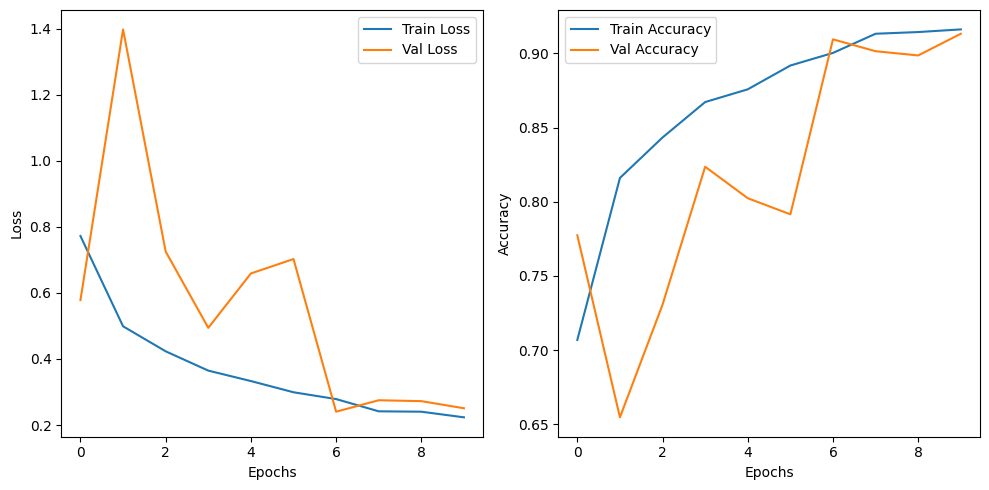

In [18]:
import matplotlib.pyplot as plt

# Tracer les graphiques
plt.figure(figsize=(10, 5))

# Graphique de la perte
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Graphique de la précision
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()





plt.tight_layout()
plt.show()

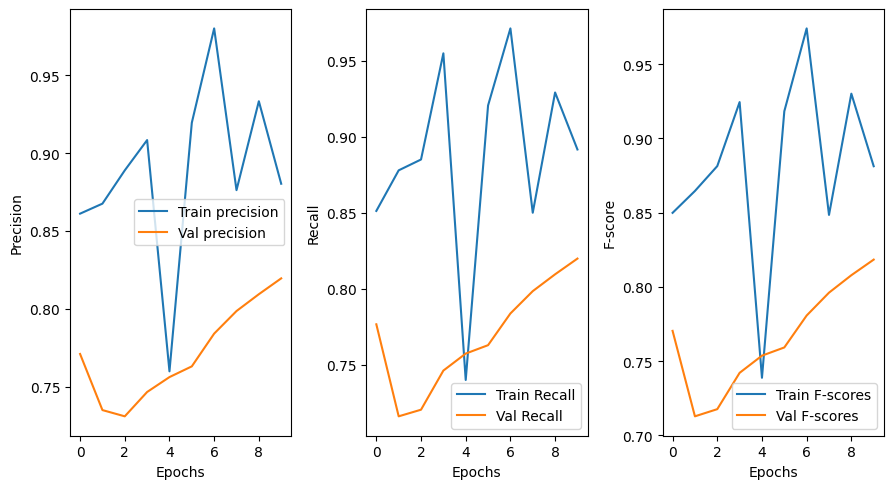

In [19]:
import matplotlib.pyplot as plt

# Plotting precision
plt.figure(figsize=(12, 5))  # Créer une nouvelle figure pour les graphiques
plt.subplot(1, 4, 1)
plt.plot(train_precisions, label='Train precision')
plt.plot(val_precisions, label='Val precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting recall
plt.subplot(1, 4, 2)
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Val Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plotting F-score
plt.subplot(1, 4, 3)
plt.plot(train_fscores, label='Train F-scores')
plt.plot(val_fscores, label='Val F-scores')
plt.xlabel('Epochs')
plt.ylabel('F-score')
plt.legend()



plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import classification_report


# Évaluation du modèle
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in tqdm(validation_dataloader, desc='Evaluating'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Générer le rapport de classification
class_names = ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers']
print(classification_report(all_labels, all_predictions, target_names=class_names))


Evaluating: 100%|██████████| 34/34 [00:24<00:00,  1.37it/s]

              precision    recall  f1-score   support

       Cargo       0.85      0.78      0.82       422
    Military       0.90      0.98      0.94       422
     Carrier       0.96      0.96      0.96       430
      Cruise       0.99      0.91      0.95       426
     Tankers       0.82      0.87      0.84       420

    accuracy                           0.90      2120
   macro avg       0.90      0.90      0.90      2120
weighted avg       0.90      0.90      0.90      2120



In [ ]:
################################################################################################